# Sentiment Analysis with Keras: Deep Learning Model

Reference: https://realpython.com/python-keras-text-classification/

## Libraries

In [51]:
import pandas as pd
from os import getcwd, path

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

from keras.models import Sequential
from keras import layers

import matplotlib.pyplot as plt

## Parameters

In [12]:
current_path = getcwd()

## 0. Data Ingest

In [14]:
filepath_dict = {'yelp':   'data/yelp_labelled.txt',
                 'amazon': 'data/amazon_cells_labelled.txt',
                 'imdb':   'data/imdb_labelled.txt'}

df_list = []

for source, filepath in filepath_dict.items():
    
    df = pd.read_csv(path.join(current_path, filepath), names=['sentence', 'label'], sep='\t')
    df['source'] = source  # Add another column filled with the source name
    df_list.append(df)

df = pd.concat(df_list)

In [15]:
df.head()

,sentence,label,source
0,Wow... Loved this place.,1,yelp
1,Crust is not good.,0,yelp
2,Not tasty and the texture was just nasty.,0,yelp
3,Stopped by during the late May bank holiday of...,1,yelp
4,The selection on the menu was great and so wer...,1,yelp


## Bag Of Words Model (BOW)

This is a common method in NLP to represent sentences (documents) as vectors.
Each word is assigned an int value, then the frecuency of that word in the sentence is counted. 

Scikit-learn.feature_extraction.text provides the following vectorizers, 
to extract the vocabulary out of a corpus data set:

1. CountVectorizer() 
2. HashingVectorizer()
3. TfidfVectorizer()

CountVectorizer performs tokenization which separates the sentences into a set of tokens as you saw previously in the vocabulary. 
It additionally removes punctuation and special characters and can apply other preprocessing to each word. 

Another approach, is to use the custom tokenizer from the NLTK library with the CountVectorizer or use other customizations to improve the performance of the model.

Reference: https://en.wikipedia.org/wiki/Bag-of-words_model

In [21]:
sentences = ['John likes ice cream', 'John hates chocolate.']

vectorizer = CountVectorizer(min_df=0, lowercase=False)
vectorizer.fit(sentences)
vectorizer.vocabulary_

{'John': 0, 'likes': 5, 'ice': 4, 'cream': 2, 'hates': 3, 'chocolate': 1}

In [22]:
# This means that both sentences have one occurrence of John, which is in the first place in the vocabulary.
vectorizer.transform(sentences).toarray()

array([[1, 0, 1, 0, 1, 1],
       [1, 1, 0, 1, 0, 0]], dtype=int64)

## 1. Baseline Model - Logistic Regression

In [25]:
# Filter data set for "yelp"
df_yelp = df[df['source'] == 'yelp']

# Get values as numpy arrays
sentences = df_yelp['sentence'].values
y = df_yelp['label'].values

# Split up training and test data
sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.25, random_state=1000)

In [26]:
from sklearn.feature_extraction.text import CountVectorizer

# Create a new CountVectorizer object
vectorizer = CountVectorizer()

# Vectorize training data set
vectorizer.fit(sentences_train)

# Transform both training and test data
X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)

In [27]:
X_train

<750x1714 sparse matrix of type '<class 'numpy.int64'>'
	with 7368 stored elements in Compressed Sparse Row format>

### Apply Logistic Regression Classifier  for yelp

In [35]:
logistic_reg = LogisticRegression()
logistic_reg.fit(X_train, y_train)
score = logistic_reg.score(X_test, y_test)

print("Accuracy:", score)

# Print Confusion Matrix
Pred_Y = logistic_reg.predict(X_test)

print("\n Confusion Matrix")
confusion_matrix(y_test, Pred_Y)/len(Pred_Y)

Accuracy: 0.796

 Confusion Matrix


array([[0.4  , 0.08 ],
       [0.124, 0.396]])

### Apply logistic Regression Classifier for all

In [38]:
for source in df['source'].unique():
    
    # Filter for every data source type
    df_source = df[df['source'] == source]
    
    # Get x and y values as np arrays
    sentences = df_source['sentence'].values
    y = df_source['label'].values

    # Split up training and test data sets
    sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.25, random_state=1000)

    # Create a new CountVectorizer Object
    # Let model learn the vocab
    vectorizer = CountVectorizer()
    vectorizer.fit(sentences_train)
    
    # Transform training and test X set ( Apply vectorization)
    X_train = vectorizer.transform(sentences_train)
    X_test  = vectorizer.transform(sentences_test)

    # Fit model and calculate score
    log_reg = LogisticRegression()
    log_reg.fit(X_train, y_train)
    score = log_reg.score(X_test, y_test)
    
    print('Accuracy for {} data: {:.4f}'.format(source, score))

Accuracy for yelp data: 0.7960
Accuracy for amazon data: 0.7960
Accuracy for imdb data: 0.7487


## Implementing Deep Neural Networks

In [47]:
# Number of features
input_dim = X_train.shape[1]  
print(input_dim)

2505


In [43]:
model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [44]:
model.compile(loss='binary_crossentropy', 
               optimizer='adam', 
               metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                25060     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 25,071
Trainable params: 25,071
Non-trainable params: 0
_________________________________________________________________


In [49]:
# Fit the neural networks model
%timeit
history = model.fit(X_train, y_train,
                     epochs=100,
                     verbose=False,
                     validation_data=(X_test, y_test),
                     batch_size=10)

In [50]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 1.0000
Testing Accuracy:  0.7754


In [57]:
history.history

{'loss': [0.6924536824226379,
  0.6459791660308838,
  0.5771241784095764,
  0.49085989594459534,
  0.4027910828590393,
  0.3277522325515747,
  0.2671937942504883,
  0.22070056200027466,
  0.184461310505867,
  0.15544338524341583,
  0.13205057382583618,
  0.11338062584400177,
  0.09821078926324844,
  0.08549293130636215,
  0.07529064267873764,
  0.0663624256849289,
  0.0589987188577652,
  0.05316704884171486,
  0.04744154214859009,
  0.04268180951476097,
  0.03876277431845665,
  0.035209864377975464,
  0.032147906720638275,
  0.029438583180308342,
  0.027081744745373726,
  0.024955134838819504,
  0.023064907640218735,
  0.021353093907237053,
  0.01972324028611183,
  0.018338682129979134,
  0.017067689448595047,
  0.015937816351652145,
  0.014837260358035564,
  0.013897322118282318,
  0.013022919185459614,
  0.012469293549656868,
  0.011460918001830578,
  0.010687082074582577,
  0.010030065663158894,
  0.009431920014321804,
  0.008880427107214928,
  0.008378063328564167,
  0.007893273606

In [60]:
plt.style.use('ggplot')

def plot_history(history):
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

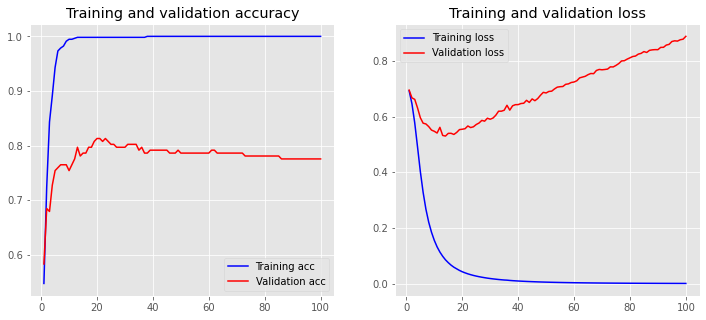

In [61]:
plot_history(history)